In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print("imported")
import random
import os
import sys
import itertools
sys.path.append('src/')
import nn
import process_data
import nibabel as nib
from math import floor, ceil
# import cv2

from __future__ import division, print_function, absolute_import
from sklearn.metrics import confusion_matrix
import scipy.sparse
from scipy.misc import imrotate, imresize
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import rotate
from skimage import exposure
from skimage.io import imread, imsave
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()
print(local_device_protos)

imported
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14723778393412094249
]


# Data Methods

In [2]:
def one_hot_encode(L, class_labels):
    """
    2D array (image) of segmentation labels -> .npy
    # One Hot Encode the label 2d array -> .npy files with dim (h, w, len(class_labels))
    # num classes will be 8? but currently dynamically allocated based on num colors in all scans.
    """
    h, w = L.shape  # Should be 482, 395 (unless resized)
    try:
        encoded = np.array([list(map(class_labels.index, L.flatten()))])

        L = encoded.reshape(h, w)

        Lhot = np.zeros((L.shape[0], L.shape[1], len(class_labels)))
        for i in range(L.shape[0]):
            for j in range(L.shape[1]):
                Lhot[i,j,L[i,j]] = 1
        return Lhot  # Should be shape (482, 395, 9)
    except Exception as e:
            print(e)

def uncode_one_hot(npy_file):
    """
    .npy file -> JPEG
    """
    pass

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
#         if image.ndim == 2:
#             plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    
def load_sparse_csr(filename):
    # Sparse matrix reading function to read our raw .npz files
    assert filename.endswith('.npz')
    loader = np.load(filename)  # filename must end with .npz
    return scipy.sparse.csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])

def get_raw_pixel_classes(trial_name, raw_nifti_dir):
    trial_segmentation = None
    
    for raw_nii in os.listdir(raw_nii_dir):
        if raw_nii.startswith(trial_name) and raw_nii.endswith(".nii"):
            if "seg" in raw_nii:
                trial_segmentation = os.path.join(raw_nii_dir, raw_nii)
                break
    
    scan_voxel = nib.load(trial_segmentation)
    struct_arr = scan_voxel.get_data()
    class_labels = sorted(list(np.unique(struct_arr)))
    return class_labels
    
def check_one_hot(encoded_img):
    print(encoded_img.shape)
    return np.all(np.sum(encoded_img, axis=2) == 1.)

def batch_img_resize(images, h = 256, w = 256):
    images_resized = np.zeros([0, newHeight, newWidth], dtype=np.uint8)
    for image in range(images.shape[0]):
        temp = imresize(images[image], [h, w], 'nearest')
        images_resized = np.append(images_resized, np.expand_dims(temp, axis=0), axis=0)
    return images_resized

def crop_cross_sec(cross_sec, height, width):
    orig_height, orig_width = cross_sec.shape
    height_remove = (orig_height - height) / 2
    width_remove = (orig_width - width) / 2
    ht_idx_1 = floor(height_remove)
    ht_idx_2 = ceil(height_remove)
    wd_idx_1 = floor(width_remove)
    wd_idx_2 = ceil(width_remove)
    
    cropped = cross_sec[ht_idx_1:orig_height-ht_idx_2, wd_idx_1:orig_width-wd_idx_2]
    
    return cropped

def pad_image(orig_img, height, width):    
    orig_height, orig_width = orig_img.shape
    
    height_pad = (height - orig_height) / 2
    width_pad = (width - orig_width) / 2
    
    height_top_pad = floor(height_pad)
    height_bot_pad =  ceil(height_pad)
    width_left_pad = floor(width_pad)
    width_right_pad = ceil(width_pad)
    
    pad_dims = ((height_top_pad, height_bot_pad), (width_left_pad, width_right_pad))
    padded_img = np.pad(orig_img, pad_width=pad_dims, mode='constant', constant_values=0)
    
    return padded_img

def load_data(processed_data_dir, raw_data_dir, height=512, width=512, use_default_classes=True):
    """
    Load both the raw, unlabeled scan data as well as corresponding labeled segmentation data.
    Can draw from an arbitrary number of scan/segmentation pairs. All raw data ends up in the
    same array, all segmentation data ends up in the same array.
    
    Args:
        processed_data_dir (str): Path to directory containing separate folders for the preprocessed
            data, where each folder contains all .npz and .png files for one scan. Name expected
            to resemble, e.g. "trial8_30_fs".
        raw_data_dir (str): Path to directory containing original .nii files of each scan being used,
            each should not be in sub-folder. Should include both unsegmented and segmented .nii.
        height (int): Height in pixels to which scan cross sections get resized.
        width (int): Width in pixels to which scan cross sections get resized.
        use_default_classes (bool): Flag indicating whether each scan being used should use default
            set of classes. If false, classes will be individually determined for each scan.
            
    Returns:
        tuple: Tuple of numpy arrays where the first array contains the raw data and is of shape
            (N, height, width), where N is total number of cross sections from all scans; the second
            contains the segmented data and is of shape (N, 512, 512, C) where C is the number of
            pixel classes. By default C is 9. Class dimension is one-hot-encoded. 
    """
    default_raw_pixel_classes = [0, 7, 8, 9, 45, 51, 52, 53, 68]
    raw_images = []
    segmentations = []
    all_raw_pixel_classes = {}
    
    for folder in os.listdir(processed_data_dir):
        if not folder.startswith('.'):
            trial_folder_path = os.path.join(processed_data_dir, folder)
            print("====")
            print(trial_folder_path)
            print("====")

            trial_files = []

            for item in os.listdir(trial_folder_path):
                item_path = os.path.join(trial_folder_path, item)
                if os.path.isfile(item_path) and not item.startswith('.'):
                    trial_files.append(item)

            trial_files = sorted(trial_files)

            
            if use_default_classes:
                all_raw_pixel_classes[folder] = default_raw_pixel_classes
            else:
                all_raw_pixel_classes[folder] = get_raw_pixel_classes(folder, raw_data_dir)

            for file in trial_files:
                print(file, end=", ")
                if 'label' in file:
                    img = imread(os.path.join(trial_folder_path, file), flatten=True)
                else:
                    img = load_sparse_csr(os.path.join(trial_folder_path, file)).toarray()            

                img = pad_image(img, height, width)
                if 'raw' in file:
                    raw_images.append(img)
                elif 'label' in file:
                    encoded_img = one_hot_encode(img, all_raw_pixel_classes[folder])
                    segmentations.append(encoded_img)
        print("")
    
    raw_images_arr = np.array(raw_images)
    segmentations_arr = np.array(segmentations)
    return raw_images_arr, segmentations_arr


def convert_seg_to_nifti(seg):
    '''
    Hardcoded right now. Todo: generalize for any scan.
    '''
    base_data_dir = "/home/jessica/Documents/hart-seg-ml/allrawnifti"
    original_vol = nib.load(os.path.join(base_data_dir, 'trial15_60_w1_volume_TRANS.nii'))
    new_header = original_vol.header.copy()
    new_nifti = nib.nifti1.Nifti1Image(seg, None, header=new_header)
    nib.save(new_nifti, '/home/jessica/Documents/hart-seg-ml/predictedsegs/trial15_60_w1_first/trial15_60_w1_first_pred_seg.nii')


# Prediction Methods

In [3]:
def predict_cross_sec(x, model, sess):
    prediction = model.predict(sess, x)
    pred_classes = np.argmax(prediction[0], axis=2)
    return pred_classes

    
def predict_whole_seg(X, model, sess):
    '''
    Todo: Crop the predictions. 
    '''
    segmented = np.empty(X.shape[:3])
    num_sections = X.shape[0]
    for i in range(num_sections):
        pred = predict_cross_sec(X[i:i+1], model, sess)
        segmented[i] = pred
        print(i, end=', ')
    return segmented



# Read Data

In [4]:
raw_nii_dir = "/Users/nozik/Documents/HARTresearch/allrawnifti"
preproc_data_dir = "/Users/nozik/Documents/HARTresearch/unet/hart-seg-ml/pipeline_test"

raw_data, seg_data = load_data(preproc_data_dir, raw_nii_dir)


====
/Users/nozik/Documents/HARTresearch/unet/hart-seg-ml/pipeline_test/trial12_30_w3
====
0_label.png, 0_raw.npz, 10_label.png, 10_raw.npz, 11_label.png, 11_raw.npz, 12_label.png, 12_raw.npz, 13_label.png, 13_raw.npz, 14_label.png, 14_raw.npz, 15_label.png, 15_raw.npz, 16_label.png, 16_raw.npz, 17_label.png, 17_raw.npz, 18_label.png, 18_raw.npz, 19_label.png, 19_raw.npz, 1_label.png, 1_raw.npz, 20_label.png, 20_raw.npz, 21_label.png, 21_raw.npz, 22_label.png, 22_raw.npz, 23_label.png, 23_raw.npz, 24_label.png, 24_raw.npz, 25_label.png, 25_raw.npz, 26_label.png, 26_raw.npz, 27_label.png, 27_raw.npz, 28_label.png, 28_raw.npz, 29_label.png, 29_raw.npz, 2_label.png, 2_raw.npz, 30_label.png, 30_raw.npz, 3_label.png, 3_raw.npz, 4_label.png, 4_raw.npz, 5_label.png, 5_raw.npz, 6_label.png, 6_raw.npz, 7_label.png, 7_raw.npz, 8_label.png, 8_raw.npz, 9_label.png, 9_raw.npz, 
====
/Users/nozik/Documents/HARTresearch/unet/hart-seg-ml/pipeline_test/trial15_60_w1
====
0_label.png, 0_raw.npz, 10_lab

In [5]:
print(raw_data.shape)
print(seg_data.shape)

(62, 512, 512)
(62, 512, 512, 9)


(512, 512)
(482, 395)


[]

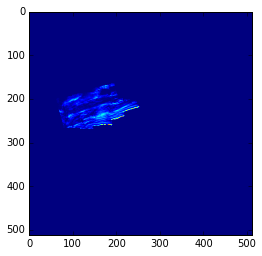

In [11]:
example_img = raw_data[0]
print(example_img.shape)
cropped_example = crop_cross_sec(example_img, 482, 395)
print(cropped_example.shape)

#plt.imshow(example_img)
plt.imshow(cropped_example)
plt.plot()


TODO: Separate out image padding from the load data method so that data can be loaded in original form, preserving original dimensions for resizing post-prediction.